In [4]:
import torch
import numpy as np
import pickle
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset
import importlib
import wandb
import torch.optim as optim
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import yaml

from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
from matplotlib.ticker import LogLocator

In [8]:
# Reading in results files
sf_paths = ['conformer_lin_det_0.1_single_flash.npy', 'conformer_dec_det_0.1_single_flash.npy', 'conformer_single_flash.npy']

cf_lin_det_10 = np.load(sf_paths[0], allow_pickle=True).item()
cf_dec_det_10 = np.load(sf_paths[1], allow_pickle=True).item()
cf_scratch_det_30 = np.load(sf_paths[2], allow_pickle=True).item()


all_results = {
    "cf_lin_det_10": cf_lin_det_10,
    "cf_dec_det_10": cf_dec_det_10
    # "cf_scratch_det_30": cf_scratch_det_30
}
model_names = list(all_results.keys())
print(model_names)

['cf_lin_det_10', 'cf_dec_det_10']


(990,)


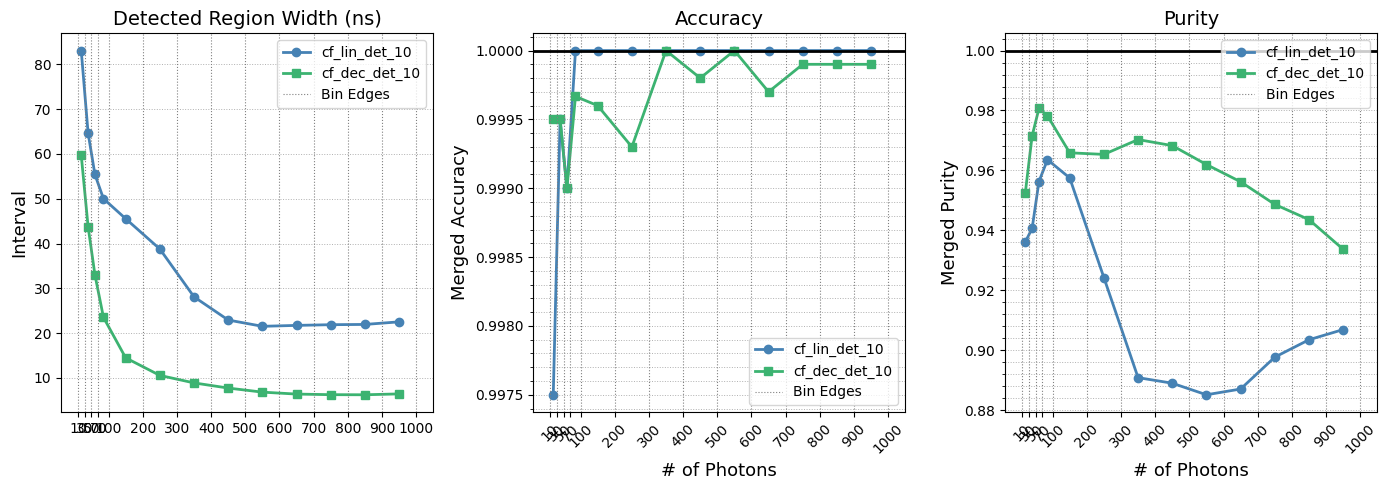

In [9]:
colors = ["steelblue", "mediumseagreen", "orange", "red", "darkblue", "pink", "darkslategrey", "darkblue", "gray"]
markers = ["o", "s", "D", "v", "^", "o", "s"]

# Convert each model's data into arrays
model_interval = {name: np.array(all_results[name]["interval"]) for name in model_names}
model_acc = {name: np.array(all_results[name]["merge_acc"]) for name in model_names}
model_pure = {name: np.array(all_results[name]["merge_pure"]) for name in model_names}

# Define binning
bin_size = 100
ref_data = next(iter(model_acc.values()))  # reference length
print(ref_data.shape)
bin_sizes = [20, 20, 20, 30] + [bin_size] * (len(ref_data) // bin_size)
bin_edges = np.cumsum([10] + bin_sizes)
bin_centers = bin_edges[:-1] + (np.array(bin_sizes) / 2)

def bin_data(arr, bin_sizes):
    """Average data into bins of variable width."""
    out, start = [], 0
    for b in bin_sizes:
        out.append(arr[start:start+b].mean())
        start += b
    return np.array(out)

# Create 1x3 plot
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharex=True)

# -------- Plot reco_frac --------
# ax = axes[0]
# for idx, name in enumerate(model_names):
#     color = colors[idx % len(colors)]
#     marker = markers[idx % len(markers)]
#     binned = bin_data(model_reco_frac[name], bin_sizes)
#     ax.plot(bin_centers, binned, label=name, color=color, marker=marker, linewidth=2)

# # Bin edges
# for i, edge in enumerate(bin_edges):
#     ax.axvline(edge, color="gray", linestyle=":", linewidth=0.8,
#                label="Bin Edges" if i == 0 else None)
# # ax.set_xlabel("# of Photons")
# ax.axhline(1, color="black", linestyle="-", linewidth=2)
# ax.set_ylabel("Reco Frac (pred / true)", fontsize=13)
# ax.set_yscale('symlog')
# ax.set_yticks(np.arange(1, 11, 1))
# ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())  # show plain numbers instead of scientific notation
# ax.tick_params(axis='y', which='major', length=5)
# # ax.set_title("Reconstructed Photon Fraction", fontsize=14)
# ax.set_xticks(bin_edges)
# # ax.yaxis.set_minor_locator(AutoMinorLocator(5))
# ax.grid(axis="y", which="both", linestyle=":", linewidth=0.7)
# ax.legend()

# -------- Plot interval --------
ax = axes[0]
for idx, name in enumerate(model_names):
    color = colors[idx % len(colors)]
    marker = markers[idx % len(markers)]
    binned = bin_data(model_interval[name], bin_sizes)
    ax.plot(bin_centers, binned, label=name, color=color, marker=marker, linewidth=2)

for i, edge in enumerate(bin_edges):
    ax.axvline(edge, color="gray", linestyle=":", linewidth=0.8,
               label="Bin Edges" if i == 0 else None)

# ax.set_xlabel("# of Photons")
ax.set_ylabel("Interval", fontsize=13)
ax.set_title("Detected Region Width (ns)", fontsize=14)
ax.set_xticks(bin_edges)
# ax.set_xticklabels(bin_edges, rotation=45)
# ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis="y", which="both", linestyle=":", linewidth=0.7)
ax.legend()

# -------- Plot Accuracy --------
ax = axes[1]
for idx, name in enumerate(model_names):
    color = colors[idx % len(colors)]
    marker = markers[idx % len(markers)]
    binned = bin_data(model_acc[name], bin_sizes)
    ax.plot(bin_centers, binned, label=name, color=color, marker=marker, linewidth=2)

for i, edge in enumerate(bin_edges):
    ax.axvline(edge, color="gray", linestyle=":", linewidth=0.8,
               label="Bin Edges" if i == 0 else None)
ax.axhline(1, color="black", linestyle="-", linewidth=2)
ax.set_xlabel("# of Photons", fontsize=13)
ax.set_ylabel("Merged Accuracy", fontsize=13)
ax.set_title("Accuracy", fontsize=14)
ax.set_xticks(bin_edges)
ax.set_xticklabels(bin_edges, rotation=45)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis="y", which="both", linestyle=":", linewidth=0.7)
ax.legend()

# -------- Plot Purity --------
ax = axes[2]
for idx, name in enumerate(model_names):
    color = colors[idx % len(colors)]
    marker = markers[idx % len(markers)]
    binned = bin_data(model_pure[name], bin_sizes)
    ax.plot(bin_centers, binned, label=name, color=color, marker=marker, linewidth=2)

for i, edge in enumerate(bin_edges):
    ax.axvline(edge, color="gray", linestyle=":", linewidth=0.8,
               label="Bin Edges" if i == 0 else None)
ax.axhline(1, color="black", linestyle="-", linewidth=2)
ax.set_xlabel("# of Photons", fontsize=13)
ax.set_ylabel("Merged Purity", fontsize=13)
ax.set_title("Purity", fontsize=14)
ax.set_xticks(bin_edges)
ax.set_xticklabels(bin_edges, rotation=45)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis="y", which="both", linestyle=":", linewidth=0.7)
ax.legend()

plt.tight_layout()
plt.show()

### Hybrid Model Results

In [2]:
# Reading in results files
sf_hybrid_paths = ['conformer_dec_reg_0.3_single_flash.npy', 'conformer_single_flash.npy']

cf_dec_30 = np.load(sf_hybrid_paths[0], allow_pickle=True).item()
cf_scratch_30 = np.load(sf_hybrid_paths[1], allow_pickle=True).item()

all_results = {
    # "cf_dec_30": cf_dec_30,
    "cf_scratch_30": cf_scratch_30
}
model_names = list(all_results.keys())
print(model_names)

['cf_scratch_30']


(990,)


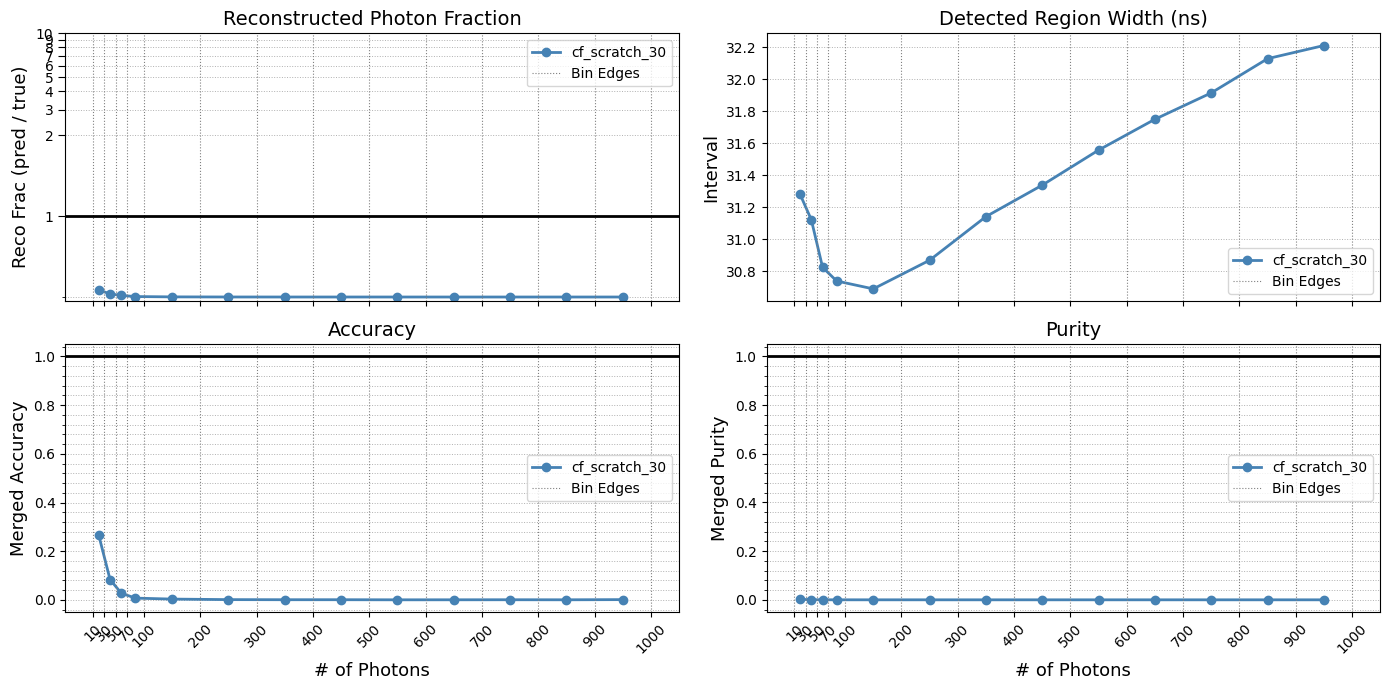

In [3]:
colors = ["steelblue", "mediumseagreen", "orange", "red", "darkblue", "pink", "darkslategrey", "darkblue", "gray"]

markers = ["o", "s", "D", "v", "^", "o", "s"]

# Convert each model's data into arrays
model_reco_frac = {name: np.array(all_results[name]["reco_frac"]) for name in model_names}
model_interval = {name: np.array(all_results[name]["interval"]) for name in model_names}
model_acc = {name: np.array(all_results[name]["merge_acc"]) for name in model_names}
model_pure = {name: np.array(all_results[name]["merge_pure"]) for name in model_names}

# Define binning
bin_size = 100
ref_data = next(iter(model_acc.values()))  # reference length
print(ref_data.shape)
bin_sizes = [20, 20, 20, 30] + [bin_size] * (len(ref_data) // bin_size)
bin_edges = np.cumsum([10] + bin_sizes)
bin_centers = bin_edges[:-1] + (np.array(bin_sizes) / 2)

def bin_data(arr, bin_sizes):
    """Average data into bins of variable width."""
    out, start = [], 0
    for b in bin_sizes:
        out.append(arr[start:start+b].mean())
        start += b
    return np.array(out)

# Create 1x2 plot
fig, axes = plt.subplots(2, 2, figsize=(14, 7), sharex=True)
axes = axes.flatten()
# -------- Plot reco_frac --------
ax = axes[0]
for idx, name in enumerate(model_names):
    color = colors[idx % len(colors)]
    marker = markers[idx % len(markers)]
    binned = bin_data(model_reco_frac[name], bin_sizes)
    ax.plot(bin_centers, binned, label=name, color=color, marker=marker, linewidth=2)

# Bin edges
for i, edge in enumerate(bin_edges):
    ax.axvline(edge, color="gray", linestyle=":", linewidth=0.8,
               label="Bin Edges" if i == 0 else None)
# ax.set_xlabel("# of Photons")
ax.axhline(1, color="black", linestyle="-", linewidth=2)
ax.set_ylabel("Reco Frac (pred / true)", fontsize=13)
ax.set_yscale('symlog')
ax.set_yticks(np.arange(1, 11, 1))
ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())  # show plain numbers instead of scientific notation
ax.tick_params(axis='y', which='major', length=5)
ax.set_title("Reconstructed Photon Fraction", fontsize=14)
ax.set_xticks(bin_edges)
# ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis="y", which="both", linestyle=":", linewidth=0.7)
ax.legend()

# -------- Plot interval --------
ax = axes[1]
for idx, name in enumerate(model_names):
    color = colors[idx % len(colors)]
    marker = markers[idx % len(markers)]
    binned = bin_data(model_interval[name], bin_sizes)
    ax.plot(bin_centers, binned, label=name, color=color, marker=marker, linewidth=2)

for i, edge in enumerate(bin_edges):
    ax.axvline(edge, color="gray", linestyle=":", linewidth=0.8,
               label="Bin Edges" if i == 0 else None)

# ax.set_xlabel("# of Photons")
ax.set_ylabel("Interval", fontsize=13)
ax.set_title("Detected Region Width (ns)", fontsize=14)
ax.set_xticks(bin_edges)
# ax.set_xticklabels(bin_edges, rotation=45)
# ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis="y", which="both", linestyle=":", linewidth=0.7)
ax.legend()

# -------- Plot Accuracy --------
ax = axes[2]
for idx, name in enumerate(model_names):
    color = colors[idx % len(colors)]
    marker = markers[idx % len(markers)]
    binned = bin_data(model_acc[name], bin_sizes)
    ax.plot(bin_centers, binned, label=name, color=color, marker=marker, linewidth=2)

for i, edge in enumerate(bin_edges):
    ax.axvline(edge, color="gray", linestyle=":", linewidth=0.8,
               label="Bin Edges" if i == 0 else None)
ax.axhline(1, color="black", linestyle="-", linewidth=2)
ax.set_xlabel("# of Photons", fontsize=13)
ax.set_ylabel("Merged Accuracy", fontsize=13)
ax.set_title("Accuracy", fontsize=14)
ax.set_xticks(bin_edges)
ax.set_xticklabels(bin_edges, rotation=45)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis="y", which="both", linestyle=":", linewidth=0.7)
ax.legend()

# -------- Plot Purity --------
ax = axes[3]
for idx, name in enumerate(model_names):
    color = colors[idx % len(colors)]
    marker = markers[idx % len(markers)]
    binned = bin_data(model_pure[name], bin_sizes)
    ax.plot(bin_centers, binned, label=name, color=color, marker=marker, linewidth=2)

for i, edge in enumerate(bin_edges):
    ax.axvline(edge, color="gray", linestyle=":", linewidth=0.8,
               label="Bin Edges" if i == 0 else None)
ax.axhline(1, color="black", linestyle="-", linewidth=2)
ax.set_xlabel("# of Photons", fontsize=13)
ax.set_ylabel("Merged Purity", fontsize=13)
ax.set_title("Purity", fontsize=14)
ax.set_xticks(bin_edges)
ax.set_xticklabels(bin_edges, rotation=45)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis="y", which="both", linestyle=":", linewidth=0.7)
ax.legend()

plt.tight_layout()
plt.show()